In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

jpm = pd.read_csv(r'C:\Users\krish\Desktop\Subjects\AppliedML\Lec-4\JPM-HistData.csv')
jpm.head()
jpmnhist = pd.read_csv(r'C:\Users\krish\Desktop\Subjects\AppliedML\Lec-4\JPM.csv')

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]#parameter coeff env eq link Y and component
    T = param0[1]# auto regressive comp
    H = param0[2]#volatility
    Q = param0[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
            v[s]=Y[s-1]-Z*u_predict[s-1]   
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_update[s]; 
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood


def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    #temp = param[4]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
            v[s]=Y[s-1]-Z*u_predict[s-1]# - temp   
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_update[s]; 
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q

            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    u_smooth = u_smooth[0:-1]
    return u_smooth





In [3]:
jpm.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,5.129630,5.018518,5.037037,0.290579,62400
1,1980-03-18,0.0,5.111111,5.037037,5.074074,0.292716,63900
2,1980-03-19,0.0,5.166667,5.111111,5.148148,0.296989,40500
3,1980-03-20,0.0,5.148148,5.092593,5.111111,0.294852,18900
4,1980-03-21,0.0,5.222222,5.111111,5.222222,0.301262,97200


In [148]:
p_t = (jpm['Adj Close'].pct_change()) #Kalman with stock return
plt.figure(figsize=(30,10))
#p_t = np.log(jpm['Close']).diff()
T = jpm.shape[0]
Y=p_t
c = []#Drop the first obs
#Y = np.random.normal(0,1,T)


<Figure size 2160x720 with 0 Axes>

In [149]:
p_t.shape

(10148,)

In [150]:
Y.shape

(10148,)

C:\Users\krish\anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys


Optimization terminated successfully.
         Current function value: 3.505882
         Iterations: 3
         Function evaluations: 36
         Gradient evaluations: 6


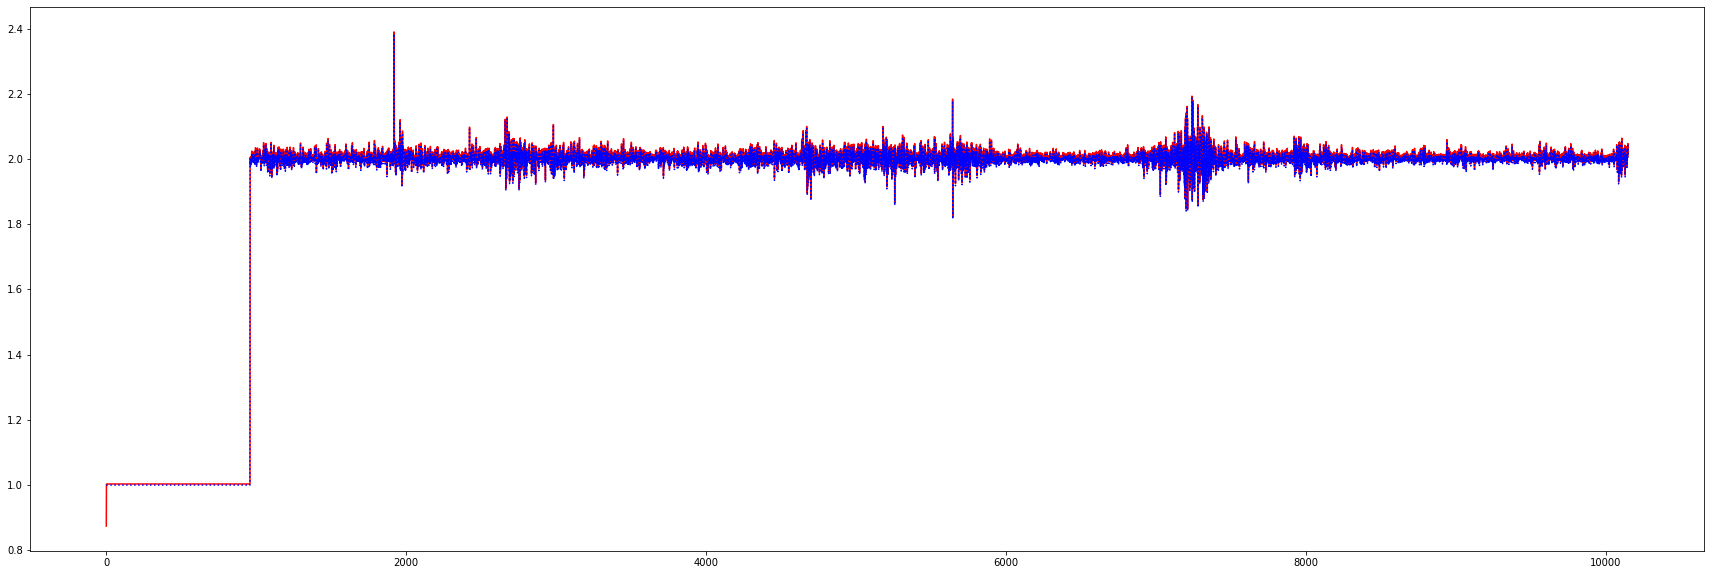

In [152]:
#Kalman
plt.figure(figsize=(30,10))
T = jpm.shape[0]
Y=p_t
param0 = np.array([0.1, 4.2, 0.179999999999999997, 2.0])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1,T,T)
plt.plot(timevec, u,'r',timevec, Y,'b:')

In [22]:
p_t = (jpm['Adj Close'].pct_change())

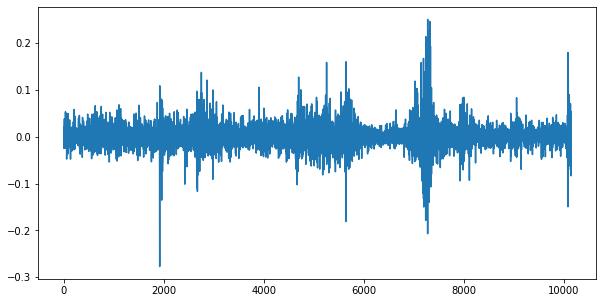

In [23]:
plt.figure(figsize=(10,5))
plt.plot(p_t)

In [153]:
mean_squared_error(Y,u)

3.8428151645861625e-05

In [154]:
print(r2_score(Y, u))

0.9995530026237041


In [155]:
import math
rmse = math.sqrt(mean_squared_error(Y,u))
print(rmse)

0.006199044413928781


In [156]:
mse = mean_squared_error(Y, u)
rmse = np.sqrt(mse)

In [157]:
mse

3.8428151645861625e-05

In [158]:
rmse

0.006199044413928781

In [14]:
jpmnhist['stock_return'] = jpmnhist['Adj Close'].pct_change()

In [15]:
jpmnhist = jpmnhist[jpmnhist['stock_return'].notna()]
jpmnhist = jpmnhist[jpmnhist.stock_return != 0]

In [16]:
p_t = (jpmnhist['stock_return']) #Kalman with stock return
plt.figure(figsize=(30,10))
#p_t = np.log(jpm['Close']).diff()
T = jpm.shape[0]
Y=p_t
c = []#Drop the first obs
#Y = np.random.normal(0,1,T)


<Figure size 2160x720 with 0 Axes>

In [19]:
jpmnhist

,Date,Open,High,Low,Close,Adj Close,Volume,stock_return
3,2016-05-19,63.529999,64.220001,62.900002,63.389999,56.592175,16076200,-0.010150
4,2016-05-20,63.860001,64.190002,63.369999,63.509998,56.699303,11862000,0.001893
5,2016-05-23,63.450001,63.869999,63.160000,63.459999,56.654667,9347500,-0.000787
6,2016-05-24,63.939999,64.769997,63.810001,64.540001,57.618855,13839400,0.017019
7,2016-05-25,64.940002,66.199997,64.919998,65.519997,58.493767,18935200,0.015184
...,...,...,...,...,...,...,...,...
1003,2020-05-11,91.110001,91.110001,89.330002,89.970001,89.970001,31872000,-0.029450
1004,2020-05-12,90.150002,90.790001,86.900002,87.029999,87.029999,27962900,-0.032678
1005,2020-05-13,86.379997,86.860001,83.400002,84.029999,84.029999,35451600,-0.034471
1006,2020-05-14,82.720001,88.110001,82.400002,87.519997,87.519997,35152500,0.041533


In [17]:
#Kalman
plt.figure(figsize=(30,10))
#p_t = jpm_data['log_return']
T = jpmnhist.shape[0]
Y=p_t
param0 = np.array([0.1, 4.2, 0.179999999999999997, 2.0])#np.array([0.1, 4, 0.17, 2.0])#np.array([0.1, 4.2, 0.17999999999999997, 2.0])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1,T,T)
plt.plot(timevec, u,'r',timevec, Y,'b:')

Optimization terminated successfully.
         Current function value: 3.505882
         Iterations: 3
         Function evaluations: 36
         Gradient evaluations: 6


C:\Users\krish\anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys


KeyError: 1

<Figure size 2160x720 with 0 Axes>

In [18]:
mean_squared_error(Y,u)

ValueError: Found input variables with inconsistent numbers of samples: [998, 1008]